# Analyzing download speeds in Kentucky counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to Kentucky counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [6]:
import geopandas as gp
from IPython.display import HTML, display
import tabulate
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Point
import adjustText as aT

## Download data

First, download the data using the link below

In [16]:
tile_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip"
tiles = gp.read_file(tile_url)

In [ ]:
# print(tiles.head())

## Get county boundaries

Then, I’ll load the Kentucky county boundaries from the U.S. Census Bureau ftp site.

In [17]:
county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" # zipfile of U.S. county boundaries
counties = gp.read_file(county_url)
ky_counties = counties.loc[counties['STATEFP'] == '21'].to_crs(4326) # filter out the Kentucky fips code and reproject to match the tiles

In [ ]:
print(ky_counties.head())

## Join tiles to counties

Now I’ll join the tiles to the counties. I use how = "inner" because I only want to include counties that have at least 1 tile.

In [18]:
tiles_in_ky_counties = gp.sjoin(tiles, ky_counties, how="inner", op='intersects')

In [19]:
# convert to Mbps for easier reading
tiles_in_ky_counties['avg_d_mbps'] = tiles_in_ky_counties['avg_d_kbps'] / 1000
tiles_in_ky_counties['avg_u_mbps'] = tiles_in_ky_counties['avg_u_kbps'] / 1000

In [ ]:
# print(tiles_in_ky_counties.head())

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [20]:
def wm(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
    
county_stats = tiles_in_ky_counties.groupby(['GEOID', 'NAMELSAD']) \
       .apply(lambda x: pd.Series({'avg_d_mbps_wt': np.average(x['avg_d_mbps'], weights=x['tests'])})) \
       .reset_index() \
       .merge(tiles_in_ky_counties.groupby(['GEOID', 'NAMELSAD']).agg(tests = ("GEOID", "size")).reset_index(), on = ['GEOID', 'NAMELSAD']) \
       

In [21]:
table_stats = county_stats.loc[county_stats['tests'] >= 50].nlargest(20, 'avg_d_mbps_wt') \
    .append(county_stats.loc[county_stats['tests'] >= 50].nsmallest(20, 'avg_d_mbps_wt')) \
    .sort_values('avg_d_mbps_wt', ascending = False)

display(HTML(tabulate.tabulate(table_stats, tablefmt='html', headers=["GEOID", "County", "Avg download speed (Mbps)", "Tests"])))

,GEOID,County,Avg download speed (Mbps),Tests
55,21111,Jefferson County,159.023,2938
33,21067,Fayette County,154.133,1170
104,21209,Scott County,151.205,441
79,21159,Martin County,150.304,208
23,21047,Christian County,146.726,486
92,21185,Oldham County,144.915,680
38,21077,Gallatin County,144.212,86
75,21151,Madison County,144.167,666
24,21049,Clark County,144.069,206
6,21013,Bell County,143.686,232


## Map the counties

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The (ftp://ftp2.census.gov/geo/tiger/)[census FTP site] makes it fairly easy to get a quick list!

In [22]:
county_data = ky_counties[['GEOID', 'geometry']].merge(county_stats, on='GEOID').to_crs(26916)

labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(county_data.avg_d_mbps_wt, (0, 25, 50, 100, 150, 200), right=False, labels = labels)

In [23]:
# add place labels 

ky_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_21_place.zip")

ky_places = ky_places.loc[ky_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
ky_places["centroid"] = ky_places["geometry"].centroid
ky_places.set_geometry("centroid", inplace = True)

1

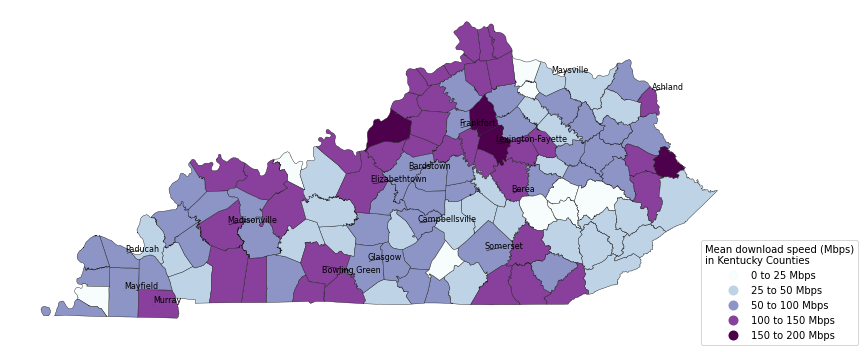

In [24]:
fig, ax = plt.subplots(1, figsize=(16, 6))

county_data.plot(column='group', cmap='BuPu', linewidth=0.4, ax=ax, edgecolor='0.1', legend=True)
ax.axis('off')

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,0.3))
leg.set_title("Mean download speed (Mbps)\nin Kentucky Counties")

texts = []

for x, y, label in zip(ky_places.geometry.x, ky_places.geometry.y, ky_places["NAME"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='black', lw=0.5))